# Predicting fluxes on grid

To do:
 
* Implement confidence intervals using `forestci` https://github.com/scikit-learn-contrib/forest-confidence-interval
* Mask with LC dataset so permenant water and urban areas are masked


In [1]:
import sys
import xarray as xr
import numpy as np
from joblib import load
from matplotlib import pyplot as plt
from datacube.utils.dask import start_local_dask

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/dea_tools')
from classification import predict_xr, HiddenPrints

In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.diskutils - INFO - Found stale lock file and directory '/local/u46/cb3058/tmp/dask-worker-space/worker-7q3wd9ze', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41767,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:37071,Total threads: 16
Dashboard: /proxy/42987/status,Memory: 44.92 GiB
Nanny: tcp://127.0.0.1:38425,


## Analysis Parameters

In [3]:
var = 'GPP'
results_name='GPP_2003_2021.nc'
model_path = '/g/data/os22/chad_tmp/NEE_modelling/results/models/AUS_GPP_model.joblib'
data_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/prediction_data_2003_2021.nc'

## Open model

In [4]:
model = load(model_path).set_params(n_jobs=1)

## Open predictor data

In [5]:
data = xr.open_dataset(data_path)

### Predict each time-step seperately

- TO DO: fix timesteps that come back from `predict_xr`

In [6]:
mask = data.to_array().isnull().any('variable')

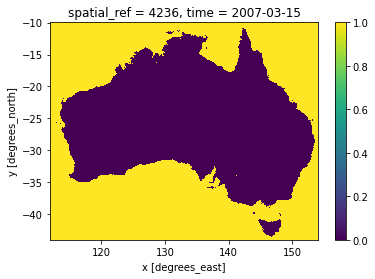

In [7]:
mask.isel(time=50).plot.imshow()

In [ ]:
results = []

i=0
#start from 3 as these time-steps doesn't have rainfall lag values
for i in range(0, len(data.time)): 
    print(" {:03}/{:03}\r".format(i + 1, len(range(0, len(data.time)))), end="")
    with HiddenPrints():
        predicted = predict_xr(model,
                            data.isel(time=i),
                            proba=False,
                            clean=True,
                              ).compute()
    
    predicted = predicted.Predictions.where(~mask.isel(time=i))
    predicted['time'] = data.isel(time=i).time.values
    results.append(predicted)
    i+=1

In [ ]:
ds = xr.concat(results, dim='time').sortby('time').rename(var)

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)